# Final Project: Face Mask Detection
## Load data

In [1]:
import os
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = '../input/face-mask-detection/datasets/processed@v2'
BATCH_SIZE = 64
EPOCHS = 20
TARGET_SIZE = [224, 224]# [168, 224] # 3:4
BASEMODEL_PATH = 'models/base_model.h5'
BESTMODEL_PATH = 'models/best_model.h5'

PROJECT_ROOT_DIR = "."
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
os.makedirs(MODELS_PATH, exist_ok=True)

In [3]:
# Get list subfolder
list_subfolder = os.listdir(TRAIN_DIR)
print('All labels : ', list_subfolder)

All labels :  ['not_mask', 'correct_mask', 'incorrect_mask']


In [4]:
import pandas as pd
LABELS = []
IMAGES = []
for subfolder in list_subfolder:
    sunfolder_path = os.path.join(TRAIN_DIR, subfolder)
    print(sunfolder_path)
    for file_name in os.listdir(sunfolder_path):
        file_path = os.path.join(subfolder, file_name)
        IMAGES.append(file_path)
        LABELS.append(subfolder)
df_train = pd.DataFrame({
    'image': IMAGES,
    'label': LABELS
})
df_train.head()

../input/face-mask-detection/datasets/processed@v2/not_mask
../input/face-mask-detection/datasets/processed@v2/correct_mask
../input/face-mask-detection/datasets/processed@v2/incorrect_mask


,image,label
0,not_mask/04168.jpg,not_mask
1,not_mask/02371.jpg,not_mask
2,not_mask/04377.jpg,not_mask
3,not_mask/00767.jpg,not_mask
4,not_mask/02360.jpg,not_mask


not_mask          4996
incorrect_mask    4700
correct_mask      4542
Name: label, dtype: int64


<AxesSubplot:>

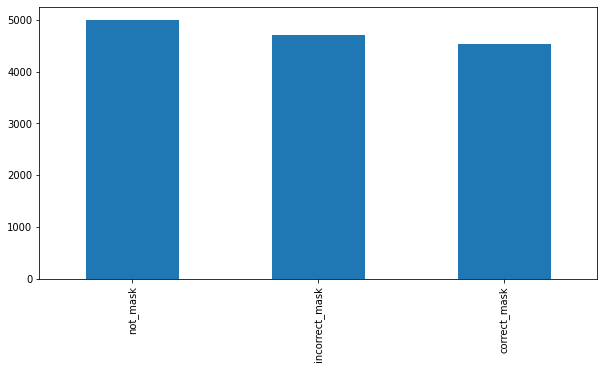

In [5]:
plt.figure(figsize=(10,5))
print(df_train.label.value_counts())
df_train.label.value_counts().plot.bar()

In [6]:
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)
np.random.seed(42)

df_train_set, df_val_set = train_test_split(df_train, test_size=0.2, random_state=25)
df_train_set.to_csv('df_train_set.csv')
df_val_set.to_csv('df_val_set.csv')

#### Info train set

not_mask          3964
incorrect_mask    3749
correct_mask      3677
Name: label, dtype: int64


<AxesSubplot:>

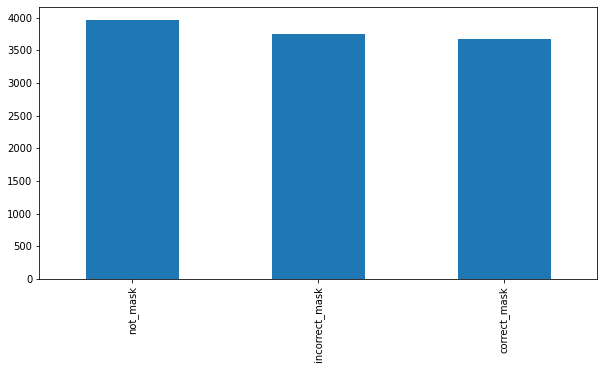

In [7]:
plt.figure(figsize=(10,5))
print(df_train_set.label.value_counts())
df_train_set.label.value_counts().plot.bar()

#### Info Validation set

not_mask          1032
incorrect_mask     951
correct_mask       865
Name: label, dtype: int64


<AxesSubplot:>

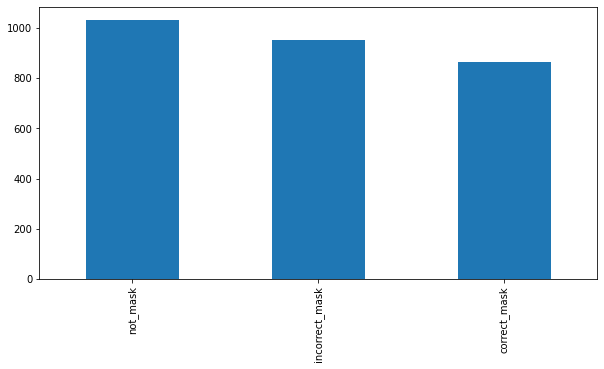

In [8]:
plt.figure(figsize=(10,5))
print(df_val_set.label.value_counts())
df_val_set.label.value_counts().plot.bar()

## Data Augmentation
### train_set with ImageDataGenerator

In [9]:
from keras.preprocessing.image import ImageDataGenerator,load_img ,img_to_array
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.05, 
                                   height_shift_range=0.05,
                                   horizontal_flip=True, 
                                   samplewise_center=True, 
                                   samplewise_std_normalization=True,
                                   fill_mode='nearest')
train_set = train_datagen.flow_from_dataframe(dataframe=df_train_set,
                                              directory=TRAIN_DIR,
                                              x_col="image",
                                              y_col="label",
                                              shuffle=True,
                                              class_mode="sparse",
                                              batch_size=BATCH_SIZE,
                                              target_size=TARGET_SIZE)

Found 11390 validated image filenames belonging to 3 classes.


### Show demo Data Augmentation

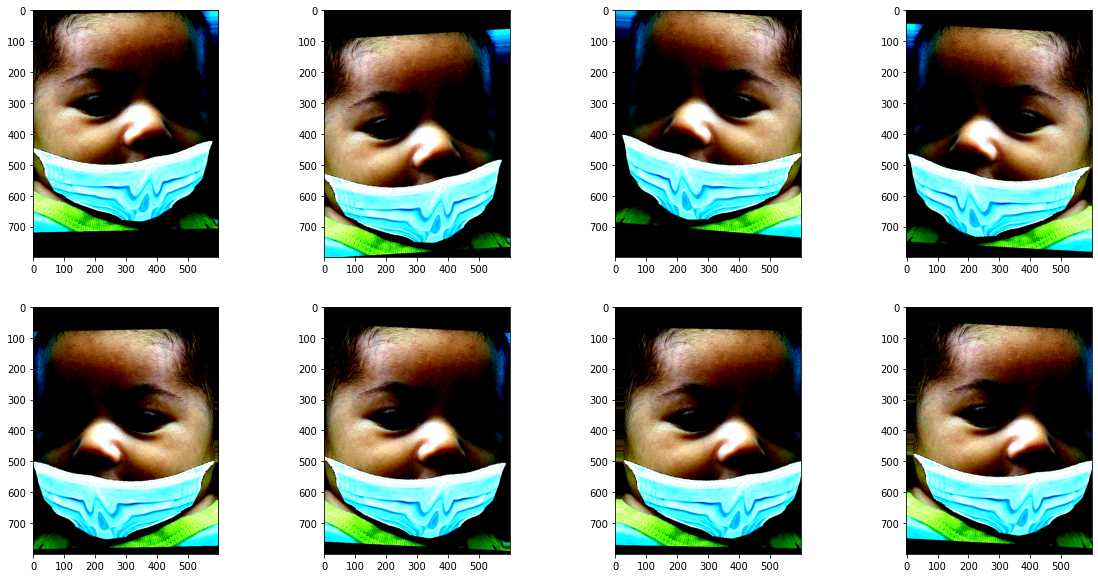

In [10]:
img = load_img("../input/face-mask-detection/datasets/processed@v2/incorrect_mask/00000_Mask_Mouth_Chin.jpg")
example_aug = img_to_array(img)/255.
example_aug = example_aug[np.newaxis]
plt.figure(figsize=(20,10))
for i,img in enumerate(train_datagen.flow(example_aug, batch_size=1)):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.squeeze(img))
    if i == 7:
        break
plt.show()

### train_set with ImageDataGenerator

In [11]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_dataframe(dataframe=df_val_set,
                                          directory=TRAIN_DIR,
                                          x_col="image",
                                          y_col="label",
                                          class_mode="sparse", 
                                          batch_size=BATCH_SIZE,
                                          target_size=TARGET_SIZE)

Found 2848 validated image filenames belonging to 3 classes.


## Build model

In [12]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.xception import Xception
from keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout, MaxPooling2D, Conv2D, BatchNormalization
from keras.models import Sequential
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

# build model
def define_model():
    base_model = Xception(weights="imagenet", 
                             include_top=False, 
                             input_shape=(224, 224, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        AveragePooling2D(pool_size=(7, 7)),
        Flatten(),
        Dense(units=512, activation='relu'),
        Dropout(0.2),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    return model

model = define_model()
model.summary()
if os.path.exists(BASEMODEL_PATH):
    os.remove(BASEMODEL_PATH)
model.save(BASEMODEL_PATH)

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________

In [13]:
import math
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-4, max_rate=0.2):
    model.compile(loss="sparse_categorical_crossentropy", optimizer='nadam', metrics=["accuracy"])
    init_weights = model.get_weights()
    iterations = math.ceil(len(X)) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, validation_data=y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    print("{} => {}".format("GL", "Good Loss"))
    print("{} => {}".format("BLL", "Bad Loss Lastest"))
    plt.figure(figsize=(10,5))
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses))])
    
    good_loss = [rates[losses.index(min(losses))], min(losses)]
    plt.plot(good_loss[0], good_loss[1], 'go')
    plt.text(good_loss[0], good_loss[1]+10**-2, 
             "GL: (lr = {:f})".format(good_loss[0]), fontsize=12)
    
    bad_index_lastest = losses.index(min(losses))
    for index in range(losses.index(min(losses))+1, losses.index(min(losses))+20):
        if (losses[index] > losses[bad_index_lastest]) and (losses[index] < 1.6):
            bad_index_lastest = index
        else: break
    bad_loss_lastest = [rates[bad_index_lastest], losses[bad_index_lastest]]
    plt.plot(bad_loss_lastest[0], bad_loss_lastest[1], 'ro')
    plt.text(bad_loss_lastest[0], bad_loss_lastest[1]+10**-2, 
             "BLL: (lr = {:f})".format(bad_loss_lastest[0]), fontsize=12)
    
    good_lr = bad_loss_lastest[0]
    
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    return good_lr

178/178 [==============================] - 291s 2s/step - loss: 3.1735 - accuracy: 0.8291 - val_loss: 1.1044 - val_accuracy: 0.3624
GL => Good Loss
BLL => Bad Loss Lastest
Good learning rate: 0.011941347271203995


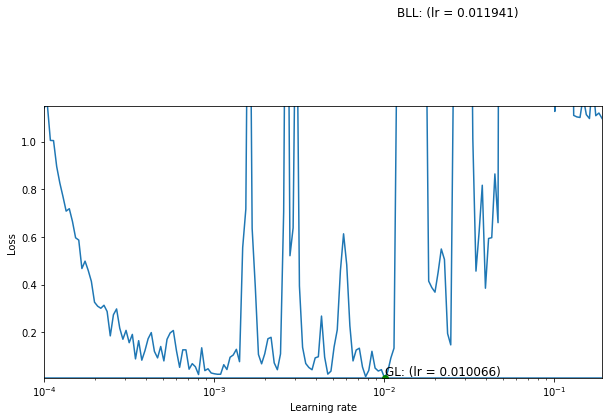

In [14]:
from keras.models import load_model

tf.random.set_seed(42)
np.random.seed(42)

model = load_model(BASEMODEL_PATH)
batch_size = BATCH_SIZE
rates, losses = find_learning_rate(model, train_set, val_set, epochs=1, batch_size=batch_size)
good_lr = plot_lr_vs_loss(rates, losses)
print('Good learning rate: {}'.format(good_lr))

## Training model

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Nadam

tf.random.set_seed(42)
np.random.seed(42)

model = load_model(BASEMODEL_PATH)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Nadam(learning_rate=good_lr), 
              metrics=["accuracy"])

print(model.optimizer.lr)

modelCheckpoint = ModelCheckpoint(
    BESTMODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
)
earlyStopping = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True,
)
history = model.fit(train_set, 
                    validation_data=val_set,
                    epochs=EPOCHS,
                    callbacks=[modelCheckpoint, earlyStopping])

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.011941347>
Epoch 1/20
178/178 [==============================] - 213s 1s/step - loss: 1.5370 - accuracy: 0.8858 - val_loss: 0.0688 - val_accuracy: 0.9786
Epoch 2/20
178/178 [==============================] - 207s 1s/step - loss: 0.0496 - accuracy: 0.9882 - val_loss: 0.0283 - val_accuracy: 0.9916
Epoch 3/20
178/178 [==============================] - 208s 1s/step - loss: 0.0897 - accuracy: 0.9863 - val_loss: 0.0647 - val_accuracy: 0.9831
Epoch 4/20
178/178 [==============================] - 207s 1s/step - loss: 0.0801 - accuracy: 0.9843 - val_loss: 0.0886 - val_accuracy: 0.9758
Epoch 5/20
178/178 [==============================] - 207s 1s/step - loss: 0.1504 - accuracy: 0.9820 - val_loss: 0.0699 - val_accuracy: 0.9909


### Evaluate model
#### Plot loss and accuracy train, val

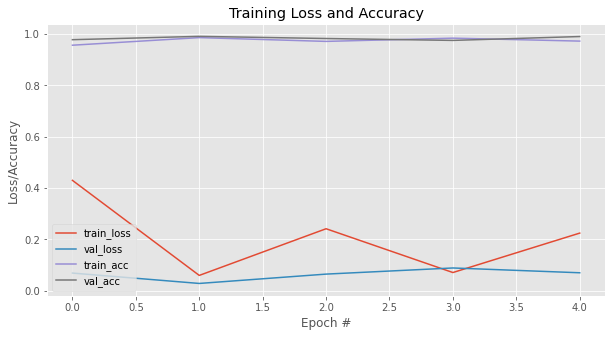

In [16]:
history = history.history
epochs_ = len(history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (10, 5))
plt.plot(np.arange(0, epochs_), history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs_), history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs_), history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs_), history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

#### Show Classification Report

In [17]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input

y_pred = []

for path in df_val_set.image:
    image_path = os.path.join(TRAIN_DIR, path)
    my_image = load_img(image_path, target_size=(224, 224))
    #preprocess the image
    my_image = img_to_array(my_image)
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    my_image = preprocess_input(my_image)

    y_pred.append(np.argmax(model.predict(my_image)))

# Y_pred = model.predict(val_set)
# y_pred = np.argmax(Y_pred, axis=1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
print(classification_report(val_set.classes, y_pred, target_names=list_subfolder))

Classification Report
                precision    recall  f1-score   support

      not_mask       0.99      1.00      0.99       865
  correct_mask       0.99      0.98      0.99       951
incorrect_mask       1.00      1.00      1.00      1032

      accuracy                           0.99      2848
     macro avg       0.99      0.99      0.99      2848
  weighted avg       0.99      0.99      0.99      2848



#### Show Confusion Matrix

In [18]:
print('Confusion Matrix')
cm = confusion_matrix(val_set.classes, y_pred)
print(cm)

Confusion Matrix
[[ 862    3    0]
 [  13  935    3]
 [   0    3 1029]]


<AxesSubplot:>

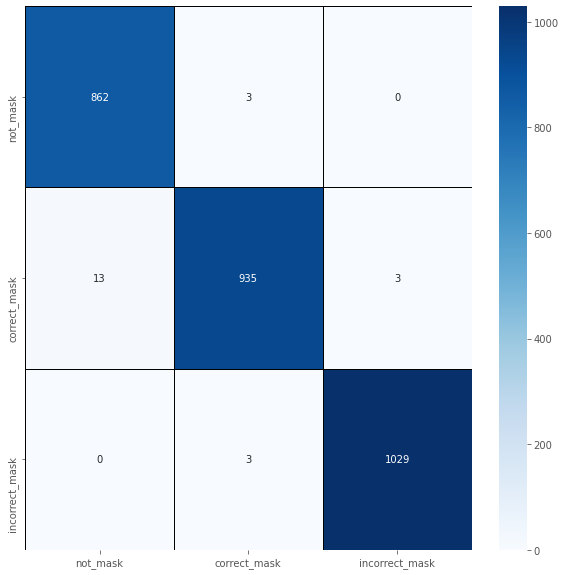

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(cm , index = list_subfolder , columns = list_subfolder)
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='' , 
            xticklabels = list_subfolder , yticklabels = list_subfolder)